<a href="https://colab.research.google.com/github/StefanGarcziu/DeepLearning_5semester/blob/main/DL_Zad5_StepanGarciu_135843.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''Trains a simple deep NN on the MNIST dataset.

Gets to 99.6% test accuracy after 40 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import RMSprop, Adam, Adadelta

from keras.utils.vis_utils import plot_model
from IPython.display import Image 
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping

# install optuna
! pip install optuna

import optuna


batch_size = 128
num_classes = 10
epochs = 50

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train0), (x_test, y_test0) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)



x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train0, num_classes)
y_test = keras.utils.to_categorical(y_test0, num_classes)



     |████████████████████████████████| 266kB 8.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 12.6MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 112kB 16.2MB/s 
     |████████████████████████████████| 133kB 14.3MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=801b48b8c02ea9fab07a628088fcab94532ad413117cd205703aea70a1053ea1
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=35bb739c962342043b5263d2dee759eed1fe9d6aed8668c5189edb996ececd14
  Stored in directory: /root/.cache/pip/whe

In [2]:
N_TRAIN_EXAMPLES = 1000 #3000
N_TEST_EXAMPLES = 10000
x_train = x_train[:N_TRAIN_EXAMPLES]
x_test = x_test[:N_TEST_EXAMPLES]
y_train = y_train[:N_TRAIN_EXAMPLES]
y_test = y_test[:N_TEST_EXAMPLES]

In [3]:
def c_model():
  # Our old fully connected (dense) network
  #model = Sequential()
  #model.add(Dense(512, activation='relu', input_shape=(784,)))
  #model.add(Dropout(0.2))
  #model.add(Dense(512, activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(512, activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(num_classes, activation='softmax'))
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  return model

In [4]:
def objective(trial):
  
  rotation_range=trial.suggest_uniform('rotation_range', .00,30)
  zoom_range=trial.suggest_uniform('zoom_range', .00,0.30)
  shift_range=trial.suggest_uniform('shift_range', .00,0.20)
  
  datagen = ImageDataGenerator( 
    rotation_range=rotation_range,
    width_shift_range=shift_range,
    height_shift_range=shift_range,
    zoom_range=zoom_range
    )

  model = c_model()

  from keras.callbacks import EarlyStopping

  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
  
  e_s=EarlyStopping(monitor='val_accuracy', patience=12, verbose=1)

  history = model.fit(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    validation_data=(x_test, y_test), 
                    callbacks=[e_s])

  score = model.evaluate(x_test, y_test,verbose=0)

  return score[1]

In [5]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )
study.optimize(objective, n_trials=30, timeout=1200)

[I 2020-12-20 22:51:38,680] A new study created in memory with name: no-name-4bc6f817-a5f5-4026-8107-9df2f4932753
[I 2020-12-20 22:52:17,940] Trial 0 finished with value: 0.9721999764442444 and parameters: {'rotation_range': 20.916325830909027, 'zoom_range': 0.20620620243882629, 'shift_range': 0.01283277155594198}. Best is trial 0 with value: 0.9721999764442444.
[I 2020-12-20 22:52:44,680] Trial 1 finished with value: 0.9735999703407288 and parameters: {'rotation_range': 25.21263979045438, 'zoom_range': 0.15977831544591267, 'shift_range': 0.028430171734570166}. Best is trial 1 with value: 0.9735999703407288.
[I 2020-12-20 22:53:11,347] Trial 2 finished with value: 0.9609000086784363 and parameters: {'rotation_range': 11.005902973486123, 'zoom_range': 0.027457952565870136, 'shift_range': 0.19821789218450042}. Best is trial 1 with value: 0.9735999703407288.
[I 2020-12-20 22:53:37,851] Trial 3 finished with value: 0.9700000286102295 and parameters: {'rotation_range': 0.2921055590690469, '

Epoch 00047: early stopping


[I 2020-12-20 22:59:22,187] Trial 16 finished with value: 0.9743000268936157 and parameters: {'rotation_range': 11.471521595269591, 'zoom_range': 0.21337977396640037, 'shift_range': 0.10382618661291648}. Best is trial 11 with value: 0.977400004863739.
[I 2020-12-20 22:59:48,800] Trial 17 finished with value: 0.9703999757766724 and parameters: {'rotation_range': 5.903102270394161, 'zoom_range': 0.27013778569827007, 'shift_range': 0.05511124759095186}. Best is trial 11 with value: 0.977400004863739.
[I 2020-12-20 23:00:15,137] Trial 18 finished with value: 0.9761000275611877 and parameters: {'rotation_range': 20.960463497763925, 'zoom_range': 0.2985079709206528, 'shift_range': 0.09475474134585396}. Best is trial 11 with value: 0.977400004863739.
[I 2020-12-20 23:00:41,508] Trial 19 finished with value: 0.9708999991416931 and parameters: {'rotation_range': 13.07185594636855, 'zoom_range': 0.20437111838872035, 'shift_range': 0.0024436309128172684}. Best is trial 11 with value: 0.9774000048

Epoch 00046: early stopping


[I 2020-12-20 23:03:45,044] Trial 26 finished with value: 0.9761000275611877 and parameters: {'rotation_range': 22.120737842399066, 'zoom_range': 0.18247396572861882, 'shift_range': 0.06911384098708957}. Best is trial 21 with value: 0.9787999987602234.
[I 2020-12-20 23:04:11,561] Trial 27 finished with value: 0.9751999974250793 and parameters: {'rotation_range': 18.641494428976998, 'zoom_range': 0.0051218166956520095, 'shift_range': 0.08555696326158907}. Best is trial 21 with value: 0.9787999987602234.
[I 2020-12-20 23:04:38,127] Trial 28 finished with value: 0.9757999777793884 and parameters: {'rotation_range': 23.221156304337264, 'zoom_range': 0.257811693348013, 'shift_range': 0.12535918973763877}. Best is trial 21 with value: 0.9787999987602234.


Epoch 00046: early stopping


[I 2020-12-20 23:05:02,631] Trial 29 finished with value: 0.9718999862670898 and parameters: {'rotation_range': 4.166374094019623, 'zoom_range': 0.21347382132350579, 'shift_range': 0.043134672036158825}. Best is trial 21 with value: 0.9787999987602234.


In [6]:
print("Number trials: {}".format(len(study.trials)))
print("Best trial:")
trial=study.best_trial
print("Value: {}".format(trial.value))
print("Params")
for key, value in trial.params.items():
  print("  {}:{}  ".format(key, value))

Number trials: 30
Best trial:
Value: 0.9787999987602234
Params
  rotation_range:19.40112405947901  
  zoom_range:0.29986539273474166  
  shift_range:0.07033804750858283  


In [7]:
rotation_range=trial.params.get('rotation_range')
zoom_range=trial.params.get('zoom_range')
shift_range=trial.params.get('shift_range')

  
datagen = ImageDataGenerator( 
    rotation_range=rotation_range,
    width_shift_range=shift_range,
    height_shift_range=shift_range,
    zoom_range=zoom_range
    )

model = c_model()

from keras.callbacks import EarlyStopping

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

e_s=EarlyStopping(monitor='val_accuracy',patience=12,verbose=1)

history = model.fit(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[e_s]) 


Epoch 1/50
8/8 [==============================] - 1s 92ms/step - loss: 2.2799 - accuracy: 0.1243 - val_loss: 2.0405 - val_accuracy: 0.5111
Epoch 2/50
8/8 [==============================] - 1s 71ms/step - loss: 2.0588 - accuracy: 0.2593 - val_loss: 1.2835 - val_accuracy: 0.6450
Epoch 3/50
8/8 [==============================] - 1s 71ms/step - loss: 1.6982 - accuracy: 0.4250 - val_loss: 0.8672 - val_accuracy: 0.7629
Epoch 4/50
8/8 [==============================] - 1s 71ms/step - loss: 1.3217 - accuracy: 0.5815 - val_loss: 0.6516 - val_accuracy: 0.7961
Epoch 5/50
8/8 [==============================] - 1s 74ms/step - loss: 1.2287 - accuracy: 0.6213 - val_loss: 0.5147 - val_accuracy: 0.8595
Epoch 6/50
8/8 [==============================] - 1s 72ms/step - loss: 1.0575 - accuracy: 0.6364 - val_loss: 0.3949 - val_accuracy: 0.8798
Epoch 7/50
8/8 [==============================] - 1s 91ms/step - loss: 1.0195 - accuracy: 0.6823 - val_loss: 0.3649 - val_accuracy: 0.9062
Epoch 8/50
8/8 [===========

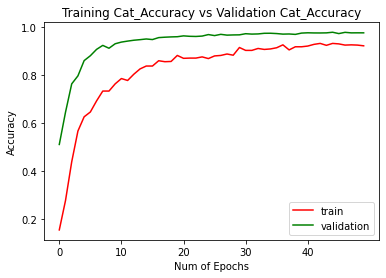

In [8]:
# Plots for training and testing process: loss and accuracy

n_epochs = len(history.history['loss'])

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
plt.legend(['train','validation'])
 

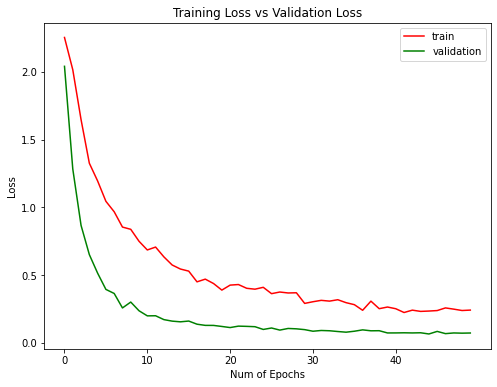

In [9]:
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()


(1000, 28, 28)


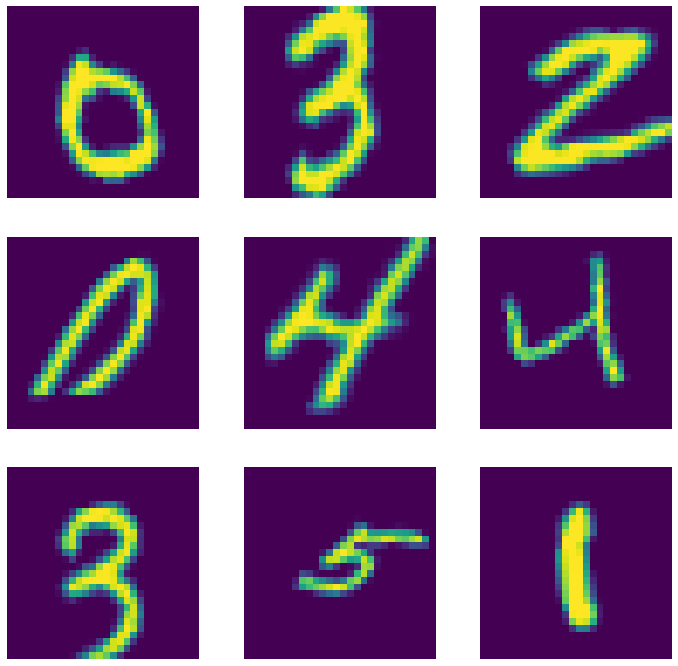

In [10]:
print(x_train.reshape((len(x_train),img_rows, img_cols)).shape)
# see example augmentation images
fig = plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[i].reshape((img_rows, img_cols)))
         plt.axis('off')
    plt.show()
    break

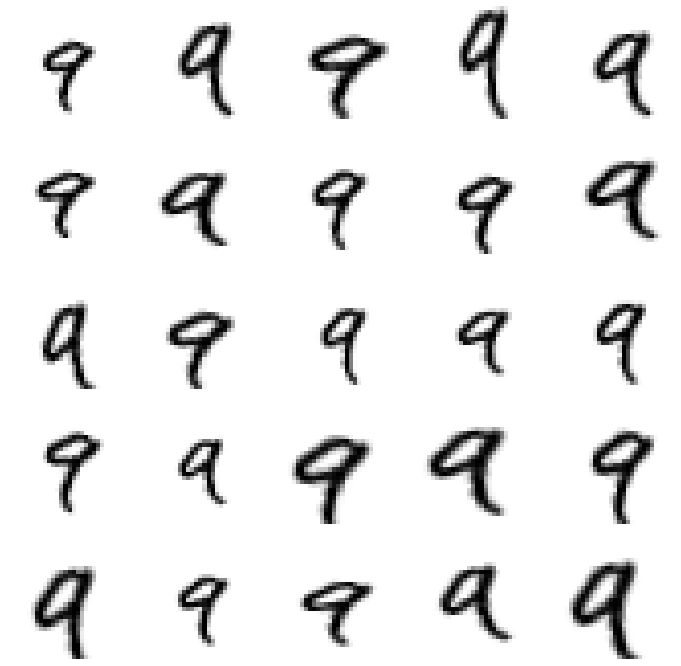

In [11]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[4:6], y_train[4:6], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].reshape((img_rows, img_cols)), cmap=plt.cm.binary, interpolation='nearest')
         plt.axis('off')
         break

plt.show()

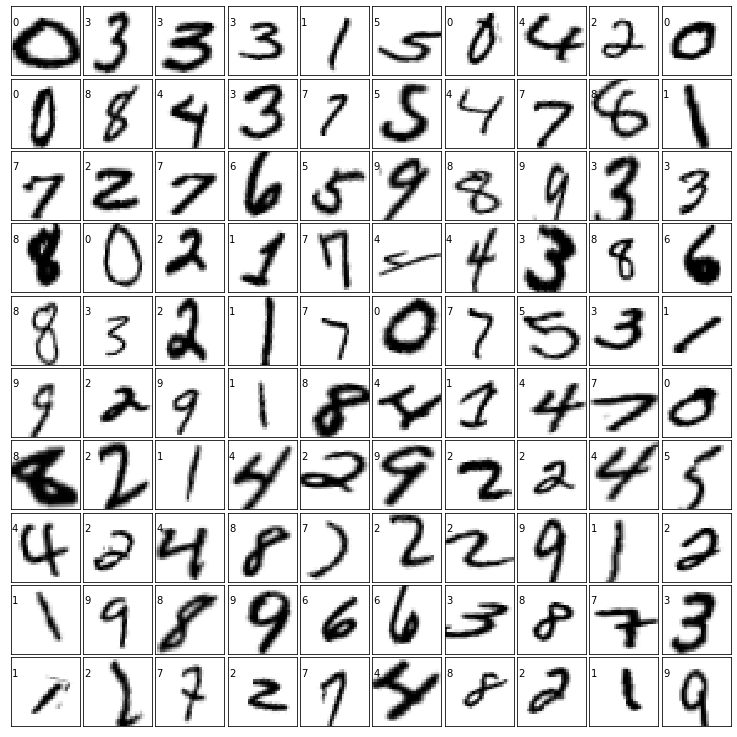

In [12]:
#visualize the digits
fig = plt.figure(figsize=(10, 10)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# generate augmented plot
X_train, Y_train = datagen.flow(x_train,y_train, batch_size=100).next()
for i in range(100):
  ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
  ax.imshow(X_train[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')
  # label the image with the target value
  ax.text(0, 7, str(np.argmax(Y_train[i])))

In [13]:
# evaluate loaded model
scores_train = model.evaluate(x_train, y_train, verbose=0)
scores_test  = model.evaluate(x_test,  y_test,  verbose=0)

print("Accuracy Train: %.2f%% , Test: %.2f%% " % (scores_train[1]*100, scores_test[1]*100 ))

Accuracy Train: 99.10% , Test: 97.49% 


In [14]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(x_test, verbose=2)

y_pred = np.argmax(Y_pred, axis=1)

y_test2 = np.argmax(y_test, axis=1)



#confusion matrix
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)



313/313 - 0s
[[ 972    0    0    0    2    0    5    1    0    0]
 [   0 1125    3    1    0    1    3    2    0    0]
 [   1    0 1026    1    0    0    1    1    2    0]
 [   0    0    5  983    0   11    0    5    4    2]
 [   0    0    0    0  958    0    5    0    0   19]
 [   1    1    0    2    0  883    3    0    1    1]
 [   3    3    0    0    3    4  944    0    1    0]
 [   0    2   51    2    1    1    0  961    1    9]
 [  14    1    8    0    5    2    5    0  930    9]
 [   3    2    0    4    6   13    2    5    7  967]]


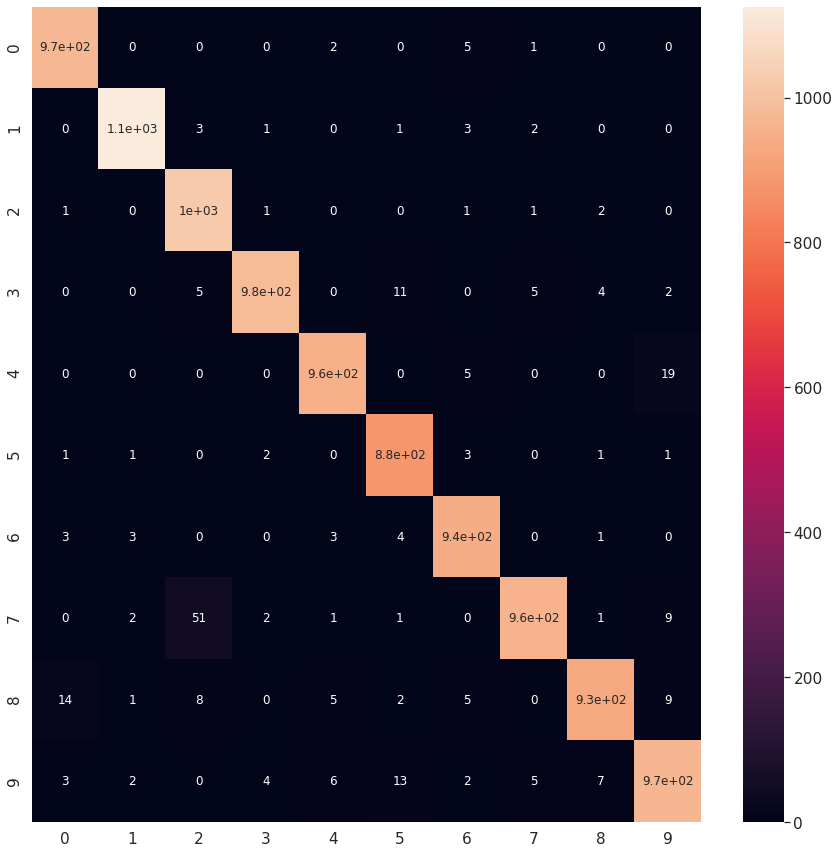

In [15]:
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),range(10))
#                     range(num_classes),
#                  range(num_classes))
#plt.figure(figsize = (10,7))
plt.figure(2,figsize = (15,15) )
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()


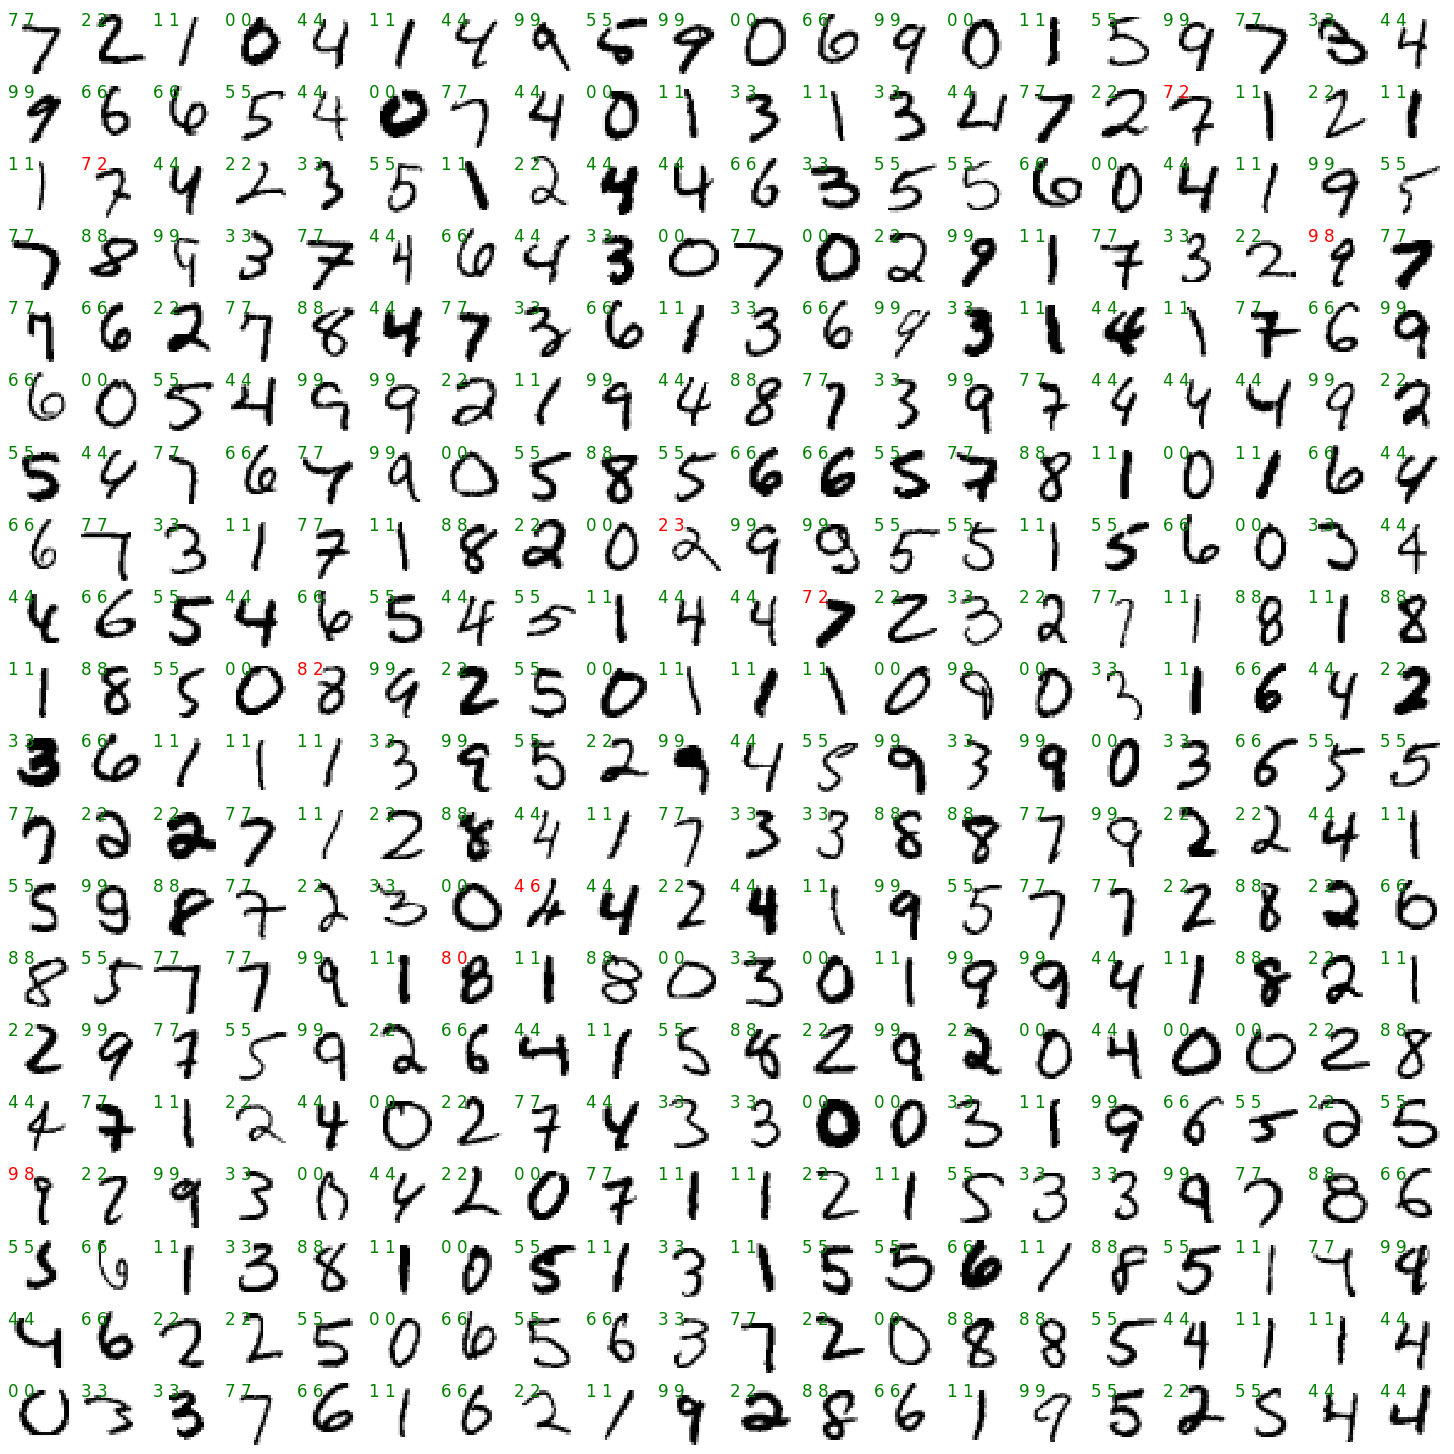

In [16]:
# use the model to predict the labels of the test data
predicted = model.predict(x_test)
expected = y_test0



# Plot the prediction
fig = plt.figure(figsize=(20, 20))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)


# plot the digits: each image is 28x28 pixels
for i in range(400):
    ax = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    if np.argmax(predicted[i]) == expected[i]:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='green')
    else:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='red')

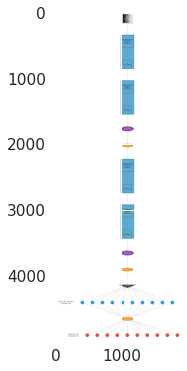

In [17]:
# Creates the graph.png file

! pip3 install keras-visualizer
from keras_visualizer import visualizer  

#create the graph.png image
visualizer(model=model, view=True, format='png', filename='graph')

#show the graph
import matplotlib.image as mpimg
img = mpimg.imread('graph.png')
imgplot = plt.imshow(img,)
plt.show()
